# Imports + general

In [ ]:
# !nvidia-smi


In [2]:
# !kill -9 $(lsof /dev/nvidia* | awk '{print $2}' | tail -n +2)

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle

import numpy as np
import pandas as pd
import random
import os

from tqdm import tqdm

import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
import torch.utils.data as data
import torchvision.datasets
from torch.utils.data.sampler import WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_fscore_support, confusion_matrix, classification_report, accuracy_score

from torchvision.models.resnet import conv3x3, _resnet, ResNet18_Weights

import matplotlib.pyplot as plt
from PIL import ImageOps, Image

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# device = 'cpu' 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Paths to data
data_folder = "/kaggle/input/kkanji-known-unknown/kkanji2_known_unknown/kkanji2_known_unknown"

In [5]:
# Define the path for the new directory
directory_path = '/kaggle/working/threshold_stuff'

# Create the directory
os.makedirs(directory_path, exist_ok=True)
print(f"Directory created at: {directory_path}")

Directory created at: /kaggle/working/threshold_stuff


In [6]:
# Clear CUDA cache
# torch.cuda.empty_cache()
# torch.cuda.reset_peak_memory_stats()

# PreactBasicBlock

In [7]:
class PreactBasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(PreactBasicBlock, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')

        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")

        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = conv3x3(inplanes, planes, stride)

        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity

        return out

    # Check what is model params and conv3x3. Also normlayer is not used.

# Cycle func

In [8]:
class BinaryThresholdFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, confidences, threshold):
        ctx.save_for_backward(confidences, threshold)
        return (confidences > threshold).float()

    @staticmethod
    def backward(ctx, grad_output):
        confidences, threshold = ctx.saved_tensors
        grad_confidences = grad_output.clone()
        grad_threshold = -grad_output.clone() * (confidences > threshold).float()
        return grad_confidences, grad_threshold

binary_threshold = BinaryThresholdFunction.apply

def cycle(model, threshold, loader, criterion, train=False, optimizer=None):
    model.eval()
    overall_loss = []
    overall_accuracy = []
    dataloader_iterator = iter(loader)

    if train:
        threshold.requires_grad = True
    else:
        threshold.requires_grad = False

    for batch_id in tqdm(range(len(loader)), desc=f"Batches train = {train}"):   
        try:
            X_batch, y_batch = next(dataloader_iterator)

        except:
            dataloader_iterator = iter(loader)
            X_batch, y_batch = next(dataloader_iterator)
    
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        if train:
            optimizer.zero_grad()

            preds = model(X_batch) 
            confidences = F.softmax(preds, dim=1).max(dim=1)[0]
            
            binary_predictions = binary_threshold(confidences, threshold)
            loss = criterion(binary_predictions, y_batch.float())
            
            loss.backward()
            optimizer.step()

        else:
            with torch.no_grad():
                preds = model(X_batch) 
                confidences= F.softmax(preds, dim=1).max(dim=1)[0]

                binary_predictions = binary_threshold(confidences, threshold)
                loss = criterion(binary_predictions, y_batch.float())

        overall_loss.append(loss.item())
        accuracy = (binary_predictions == y_batch.float()).float().mean().item()
        overall_accuracy.append(accuracy)

    mean_loss = sum(overall_loss) / len(loader)
    mean_accuracy = sum(overall_accuracy) / len(loader)
    return mean_loss, mean_accuracy



        

# Dataloaders

In [9]:
# Dataset initialization
def get_dataloaders(batch_size: int = 4096, train_test_indices_path: str = None):
    # Define transformations
    my_transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize(64),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize each channel to (-1, 1)  # Normalize to (-1, 1)
            ])
        
    full_dataset = datasets.ImageFolder(root=data_folder, transform=my_transform)

    train_indices = []
    test_indices = []
    # Split dataset into training and testing sets

    if train_test_indices_path is not None and os.path.exists(train_test_indices_path):
        with open(train_test_indices_path, "rb") as f:
            indices = pickle.load(f)
            train_indices = indices["train_indices"]
            test_indices = indices["test_indices"]
                
    else:
        train_indices, test_indices = train_test_split(
            list(range(len(full_dataset))),
            test_size=0.3,
            stratify=[label for _, label in full_dataset.samples]
        )
        
        # Save indices
        with open(train_test_indices_path, "wb") as f:
            pickle.dump({"train_indices": train_indices, "test_indices": test_indices}, f)

    train_dataset = data.Subset(full_dataset, train_indices)
    test_dataset = data.Subset(full_dataset, test_indices)

    # Create DataLoaders
    trainloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    testloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return trainloader, testloader, full_dataset

# Getting stuff for training

In [10]:
def getting_stuff_for_training(pathes: dict = None, lr: float = 1e-3, scheduler_step_size: int = 10, scheduler_gamma: float = 0.1):    

    stuff = {}
    last_epoch = 0

    if os.path.exists(pathes["last_epoch"]):
        last_epoch = np.load(pathes["last_epoch"])
    stuff["last_epoch"] = last_epoch

    model = _resnet(PreactBasicBlock, [2, 2, 2, 2], None, progress=False) # 'resnet18'
    model.fc = nn.Linear(model.fc.in_features, 300)
    
    if os.path.exists(pathes["model"]):
        model.load_state_dict(torch.load(pathes["model"]))
    model = model.to(device)
    stuff["model"] = model

    threshold = nn.Parameter(torch.tensor(0.9, requires_grad=True))
    if os.path.exists(pathes["threshold"]):
        threshold = torch.load(pathes["threshold"])
    stuff["threshold"] = threshold

    optimizer = torch.optim.Adam([threshold], lr=lr) # , weight_decay=0.)
    if os.path.exists(pathes["optimizer"]):
        optimizer.load_state_dict(torch.load(pathes["optimizer"]))
    stuff["optimizer"] = optimizer

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
    if os.path.exists(pathes["scheduler"]):
        scheduler.load_state_dict(torch.load(pathes["scheduler"]))
    stuff["scheduler"] = scheduler

    threshold_history = []
    if os.path.exists(pathes["threshold_history"]):
        train_loss_history = list(np.load(pathes["threshold_history"]))
    stuff["threshold_history"] = threshold_history

    train_loss_history = []
    if os.path.exists(pathes["train_loss_history"]):
        train_loss_history = list(np.load(pathes["train_loss_history"]))
    stuff["train_loss_history"] = train_loss_history

    train_accuracy_history = []
    if os.path.exists(pathes["train_accuracy_history"]):
        train_accuracy_history = list(np.load(pathes["train_accuracy_history"]))
    stuff["train_accuracy_history"] = train_accuracy_history

    val_loss_history = []
    if os.path.exists(pathes["val_loss_history"]):
        val_loss_history = list(np.load(pathes["val_loss_history"]))
    stuff["val_loss_history"] = val_loss_history

    val_accuracy_history = []
    if os.path.exists(pathes["val_accuracy_history"]):
        val_accuracy_history = list(np.load(pathes["val_accuracy_history"]))
    stuff["val_accuracy_history"] = val_accuracy_history

    max_val_accuracy = 0
    if os.path.exists(pathes["max_val_accuracy"]):
        max_val_accuracy = np.load(pathes["max_val_accuracy"])
    stuff["max_val_accuracy"] = max_val_accuracy

    early_stopping = 5
    if os.path.exists(pathes["early_stopping"]):
        early_stopping = np.load(pathes["early_stopping"])
    stuff["early_stopping"] = early_stopping

    return stuff

# Plot func

In [11]:
def custom_plot(train_data : list = None, val_data : list = None, title: str = None,  ylabel: str = None):
    plt.plot(train_data, label="train")
    plt.plot(val_data, label="validation")
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(title)
    return

In [12]:
import matplotlib.pyplot as plt

def custom_plot_threshold(
    train_data: list = None,
    val_data: list = None,
    threshold_history: list = None,
    title: str = None,
    ylabel: str = None,
):
    if threshold_history is None:
        raise ValueError("threshold_history parameter cannot be None.")
    if len(train_data) != len(threshold_history) or len(val_data) != len(threshold_history):
        raise ValueError("train_data, val_data, and threshold_history must have the same length.")
    
    plt.figure(figsize=(10, 6))
    plt.plot(threshold_history, train_data, label="Train", marker="o")
    plt.plot(threshold_history, val_data, label="Validation", marker="o")
    
    # Labeling the axes
    plt.xlabel("Threshold Value")
    plt.ylabel(ylabel)
    plt.title(title)
    
    # Ensure all ticks and data points are visible
    plt.xticks(threshold_history, rotation=45)
    plt.legend()
    plt.grid(visible=True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


# Create pathes vocabulary

In [13]:
def create_pathes_vocabulary(path : str = None):
    pathes = {"threshold": f"{path}/threshold.pth", "threshold_history": f"{path}/threshold_history.npy", "last_epoch": f"{path}/last_epoch.npy", "model": f"{path}/model.pth", "optimizer": f"{path}/optimizer.pth", 
    "scheduler": f"{path}/scheduler.pth", "train_loss_history": f"{path}/train_loss_history.npy", "train_accuracy_history": f"{path}/train_accuracy_history.npy", 
    "val_loss_history": f"{path}/val_loss_history.npy", "val_accuracy_history": f"{path}/val_accuracy_history.npy", 
    "max_val_accuracy": f"{path}/max_val_accuracy.npy", "early_stopping": f"{path}/early_stopping.npy"}

    return pathes
    

# Train loop

In [14]:
def train_loop(trainloader, testloader, stuff : dict = None, criterion=nn.BCELoss(), save_path : str = None, epochs : int = 100, model_name : str = None):

    last_epoch = stuff["last_epoch"]
    epochs += last_epoch 
    threshold_history = stuff["threshold_history"]

    model = stuff["model"]
    threshold = stuff["threshold"]
    optimizer = stuff["optimizer"]
    scheduler = stuff["scheduler"]

    train_loss_history = stuff["train_loss_history"]
    train_accuracy_history = stuff["train_accuracy_history"]

    val_loss_history = stuff["val_loss_history"]
    val_accuracy_history = stuff["val_accuracy_history"]

    max_val_accuracy = stuff["max_val_accuracy"]
    early_stopping = stuff["early_stopping"]

    for epoch in tqdm(range(last_epoch, epochs)):

        train_loss, train_accuracy = cycle(model, threshold, trainloader, criterion, train=True, optimizer=optimizer) #train(model, trainloader, criterion, optimizer, batch_size)
        torch.cuda.empty_cache()
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)

        val_loss, val_accuracy = cycle(model, threshold, testloader, criterion) #validate(model, testloader, criterion, batch_size)
        torch.cuda.empty_cache()
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        scheduler.step()

        threshold_history.append(round(threshold.item(), 5))
        print('Threshold value:', threshold_history[-1])
        print('Epoch:', epoch+1)
        print('Train: loss', train_loss, 'accuracy', train_accuracy)
        print('Validation: loss', val_loss, 'accuracy', val_accuracy)
        

        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            early_stopping = 5

            # Save the model
            torch.save(model.state_dict(), f'{save_path}/model.pth')

            # Save the threshold
            torch.save(threshold, f'{save_path}/threshold.pth')

            # Save the optimizer
            torch.save(optimizer.state_dict(), f'{save_path}/optimizer.pth')

            # Save the scheduler
            torch.save(scheduler.state_dict(), f'{save_path}/scheduler.pth')

            # Save the threshold history
            np.save(f'{save_path}/threshold_history.npy', threshold_history)

            # Save the loss history
            np.save(f'{save_path}/train_loss_history.npy', train_loss_history)
            np.save(f'{save_path}/val_loss_history.npy', val_loss_history)

            # Save the accuracy history
            np.save(f'{save_path}/train_accuracy_history.npy', train_accuracy_history)
            np.save(f'{save_path}/val_accuracy_history.npy', val_accuracy_history)

            # Save the last epoch
            np.save(f'{save_path}/last_epoch.npy', epoch+1)

            # Save max validation accuracy
            np.save(f'{save_path}/max_val_accuracy.npy', max_val_accuracy)

            # Save early stopping
            np.save(f'{save_path}/early_stopping.npy', early_stopping)

        else:
            early_stopping -= 1

        if early_stopping == 0:
            break


    print(f'Best validation accuracy for {model_name}:', max(val_accuracy_history), 'Epoch', val_accuracy_history.index(max(val_accuracy_history))+1)
    return train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history, threshold_history

# Testing model metrics

In [15]:
def testing_models_metrics(class_amount: int = 300, model_suff_path: str = None, train_test_indices_path: str = None, dataloaders: dict = None):

    model = _resnet(PreactBasicBlock, [2, 2, 2, 2], None, False)  # 'resnet18'
    model.fc = nn.Linear(model.fc.in_features, class_amount)
    threshold = nn.Parameter(torch.tensor(0.5, requires_grad=True))

    # Load model weights
    if model_suff_path is not None:
        if os.path.exists(f"{model_suff_path}/model.pth"):
            model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
        if os.path.exists(f"{model_suff_path}/threshold.pth"):
            threshold = torch.load(f"{model_suff_path}/threshold.pth")

    criterion = nn.BCELoss()

    # Load 
    if dataloaders is None:
        trainloader, testloader, original_dataset = get_dataloaders(batch_size=4096, train_test_indices_path=train_test_indices_path)
    else:
        testloader = dataloaders["testloader"]
        original_dataset = dataloaders["original_dataset"]
    
    model = model.to(device)

    """
    # Test loss and accuracy
    if casia_hwdb is None:
        test_loss, test_accuracy = cycle(model, testloader, criterion)
        print('Test: loss', test_loss, 'accuracy', test_accuracy)
    """

    all_preds, all_labels = [], []

    scaler = torch.cuda.amp.GradScaler()
    model.eval()
    threshold.requires_grad = False
    with torch.no_grad(), torch.cuda.amp.autocast():
        for data in tqdm(testloader, desc="Evaluating"):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            
            confidences = torch.max(F.softmax(outputs, dim=1), 1)[0]
            binary_predictions = confidences > threshold

            all_preds.extend(binary_predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    confusion_matrix_ = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=original_dataset.classes, output_dict=True)
    f1_score = report["macro avg"]["f1-score"] 

    print(f"Accuracy: {accuracy}")
    print(f"F1 score: {f1_score}")
    print(f"Confusion matrix: {confusion_matrix_}")
    print(f"Report: {report}")


# Threshold logic

In [16]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji-known-unknown/threshold_stuff/threshold_stuff")

trainloader, testloader, original_dataset = get_dataloaders(batch_size=4096, train_test_indices_path="/kaggle/working/train_test_indices_threshold.pkl")

stuff = getting_stuff_for_training(pathes=pathes)

dataloaders = {"trainloader": trainloader, "testloader": testloader, "original_dataset": original_dataset}

<ipython-input-10-6772763f2c87>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pathes["model"]))


In [17]:
# Train loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history, threshold_history = train_loop(trainloader, testloader, stuff=stuff, save_path="/kaggle/working/threshold_stuff", model_name="Threshold")

Batches train = True: 100%|██████████| 17/17 [01:00<00:00,  3.58s/it]

  1%|          | 1/100 [01:27<2:25:00, 87.89s/it]

Threshold value: 0.91687
Epoch: 1
Train: loss 10.687858637641458 accuracy 0.8931214143248165
Validation: loss 10.309173226356506 accuracy 0.8969082683324814



Batches train = True: 100%|██████████| 17/17 [00:31<00:00,  1.85s/it]

  2%|▏         | 2/100 [02:13<1:42:31, 62.77s/it]

Threshold value: 0.93325
Epoch: 2
Train: loss 9.748500319088206 accuracy 0.9025149976505953
Validation: loss 9.326104879379272 accuracy 0.9067389518022537



Batches train = True: 100%|██████████| 17/17 [00:32<00:00,  1.88s/it]

  3%|▎         | 3/100 [02:59<1:29:16, 55.22s/it]

Threshold value: 0.94869
Epoch: 3
Train: loss 8.723383398617015 accuracy 0.9127661655930912
Validation: loss 8.372011303901672 accuracy 0.9162798896431923



Batches train = True: 100%|██████████| 17/17 [00:30<00:00,  1.80s/it]

  4%|▍         | 4/100 [03:43<1:21:25, 50.89s/it]

Threshold value: 0.96286
Epoch: 4
Train: loss 7.806005590102252 accuracy 0.9219399445197162
Validation: loss 7.494614124298096 accuracy 0.9250538647174835



Batches train = True: 100%|██████████| 17/17 [00:31<00:00,  1.83s/it]

  5%|▌         | 5/100 [04:28<1:17:09, 48.73s/it]

Threshold value: 0.97552
Epoch: 5
Train: loss 6.9743713491103225 accuracy 0.9302562860881581
Validation: loss 6.6877763867378235 accuracy 0.9331222400069237



Batches train = True: 100%|██████████| 17/17 [00:31<00:00,  1.86s/it]

  6%|▌         | 6/100 [05:13<1:14:18, 47.43s/it]

Threshold value: 0.98634
Epoch: 6
Train: loss 6.272003033581902 accuracy 0.9372799712068894
Validation: loss 6.139566600322723 accuracy 0.9386043399572372



Batches train = True: 100%|██████████| 17/17 [00:31<00:00,  1.83s/it]

  7%|▋         | 7/100 [05:58<1:12:21, 46.69s/it]

Threshold value: 0.99479
Epoch: 7
Train: loss 6.41630885180305 accuracy 0.935836911201477
Validation: loss 7.527781069278717 accuracy 0.9247221946716309



Batches train = True: 100%|██████████| 17/17 [00:30<00:00,  1.81s/it]

  8%|▊         | 8/100 [06:43<1:10:44, 46.13s/it]

Threshold value: 1.00008
Epoch: 8
Train: loss 12.653556262745576 accuracy 0.8734644370920518
Validation: loss 49.971763134002686 accuracy 0.5002823695540428



Batches train = True: 100%|██████████| 17/17 [00:32<00:00,  1.92s/it]

  9%|▉         | 9/100 [07:30<1:10:17, 46.35s/it]

Threshold value: 1.00162
Epoch: 9
Train: loss 50.026603923124426 accuracy 0.4997339616803562
Validation: loss 49.971763134002686 accuracy 0.5002823695540428



Batches train = True: 100%|██████████| 17/17 [00:32<00:00,  1.94s/it]

 10%|█         | 10/100 [08:17<1:09:55, 46.62s/it]

Threshold value: 1.00189
Epoch: 10
Train: loss 50.026603923124426 accuracy 0.4997339616803562
Validation: loss 49.971763134002686 accuracy 0.5002823695540428



Batches train = True: 100%|██████████| 17/17 [00:32<00:00,  1.92s/it]

 10%|█         | 10/100 [09:04<1:21:38, 54.42s/it]

Threshold value: 1.0019
Epoch: 11
Train: loss 50.026603923124426 accuracy 0.4997339616803562
Validation: loss 49.971763134002686 accuracy 0.5002823695540428
Best validation accuracy for Threshold: 0.9386043399572372 Epoch 6


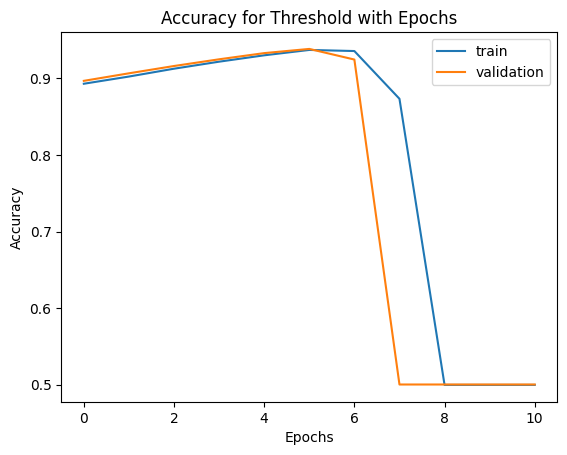

In [18]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for Threshold with Epochs", "Accuracy")

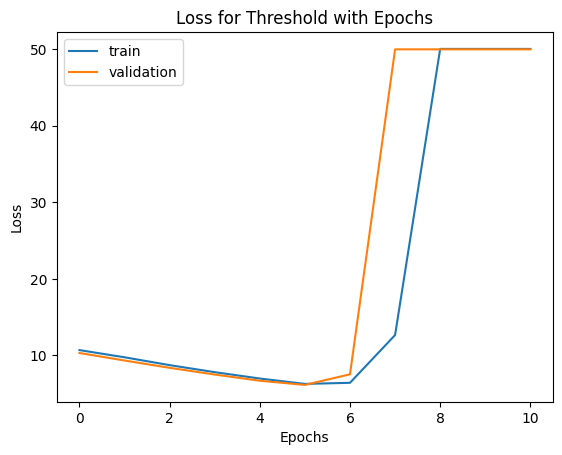

In [19]:
custom_plot(train_loss_history, val_loss_history, "Loss for Threshold with Epochs", "Loss")

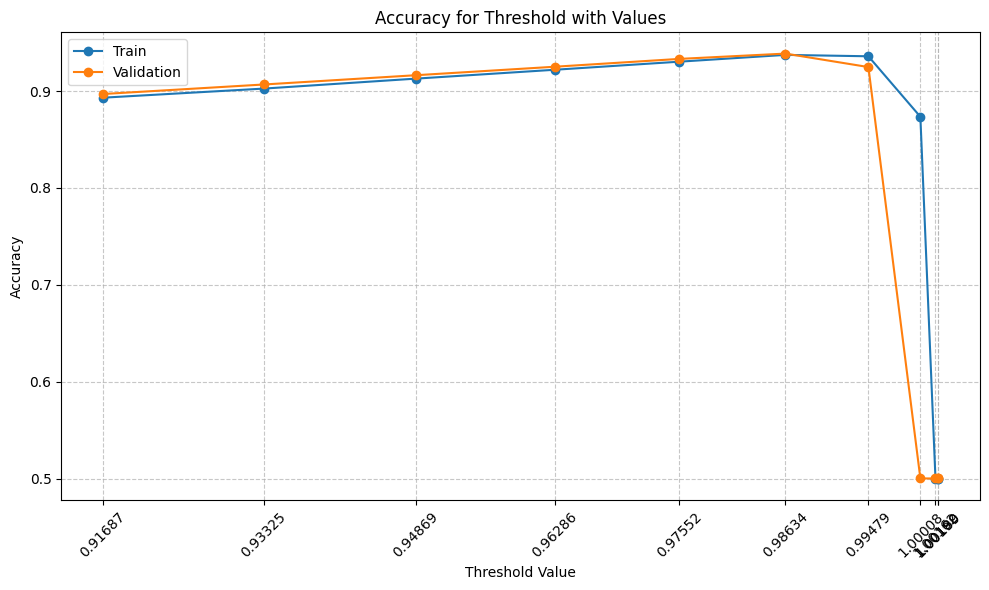

In [20]:
custom_plot_threshold(train_accuracy_history, val_accuracy_history, threshold_history, "Accuracy for Threshold with Values", "Accuracy")

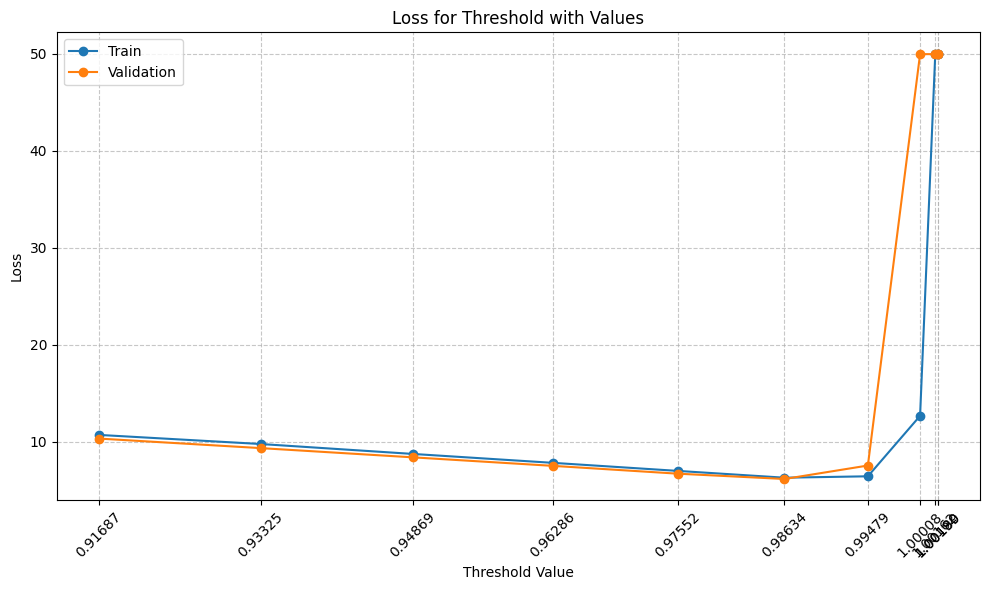

In [21]:
custom_plot_threshold(train_loss_history, val_loss_history, threshold_history, "Loss for Threshold with Values", "Loss")

In [22]:
testing_models_metrics(class_amount=300, model_suff_path="/kaggle/working/threshold_stuff", train_test_indices_path="/kaggle/working/train_test_indices_threshold.pkl", dataloaders=dataloaders)

<ipython-input-15-66497e14c521>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
<ipython-input-15-66497e1

Accuracy: 0.9386734693877551
F1 score: 0.9386718516091541
Confusion matrix: [[13723   977]
 [  826 13874]]
Report: {'0_unknown': {'precision': 0.9432263385799712, 'recall': 0.9335374149659864, 'f1-score': 0.9383568669014325, 'support': 14700}, '1_known': {'precision': 0.9342131842973537, 'recall': 0.9438095238095238, 'f1-score': 0.9389868363168759, 'support': 14700}, 'accuracy': 0.9386734693877551, 'macro avg': {'precision': 0.9387197614386624, 'recall': 0.9386734693877551, 'f1-score': 0.9386718516091541, 'support': 29400}, 'weighted avg': {'precision': 0.9387197614386624, 'recall': 0.9386734693877551, 'f1-score': 0.9386718516091542, 'support': 29400}}


In [23]:
loaded_threshold = torch.load("/kaggle/working/threshold_stuff/threshold.pth")
# Print the value
print(f"Threshold value: {loaded_threshold.item()}")

Threshold value: 0.9863355755805969


<ipython-input-23-8db349f9cef3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_threshold = torch.load("/kaggle/working/threshold_stuff/threshold.pth")
